In [5]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('d:/new/Fire-Detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

d:/new/Fire-Detection\0\1.jpg
d:/new/Fire-Detection\0\10.jpg
d:/new/Fire-Detection\0\100.jpg
d:/new/Fire-Detection\0\101.jpg
d:/new/Fire-Detection\0\102.jpg
d:/new/Fire-Detection\0\103.jpg
d:/new/Fire-Detection\0\104.jpg
d:/new/Fire-Detection\0\105.jpg
d:/new/Fire-Detection\0\106.jpg
d:/new/Fire-Detection\0\107.jpg
d:/new/Fire-Detection\0\108.jpg
d:/new/Fire-Detection\0\109.jpg
d:/new/Fire-Detection\0\11.jpeg
d:/new/Fire-Detection\0\110.jpg
d:/new/Fire-Detection\0\111.jpg
d:/new/Fire-Detection\0\112.jpg
d:/new/Fire-Detection\0\113.jpg
d:/new/Fire-Detection\0\114.jpg
d:/new/Fire-Detection\0\115.jpg
d:/new/Fire-Detection\0\116.jpg
d:/new/Fire-Detection\0\117.jpg
d:/new/Fire-Detection\0\118.jpg
d:/new/Fire-Detection\0\119.jpg
d:/new/Fire-Detection\0\12.jpg
d:/new/Fire-Detection\0\120.jpg
d:/new/Fire-Detection\0\121.jpg
d:/new/Fire-Detection\0\122.jpeg
d:/new/Fire-Detection\0\123.jpg
d:/new/Fire-Detection\0\124.jpg
d:/new/Fire-Detection\0\125.jpg
d:/new/Fire-Detection\0\126.jpg
d:/new/Fire

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import os
import pandas as pd


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [9]:
dataset_path = "d:/new/Fire-Detection"

base_dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Keep only 0 and 1 (nofire/fire) if extra folders exist.
allowed_classes = ["0", "1"]
if set(allowed_classes).issubset(set(base_dataset.classes)) and len(base_dataset.classes) != len(allowed_classes):
    class_to_idx = {c: i for i, c in enumerate(allowed_classes)}
    samples = []
    targets = []
    for path, label in base_dataset.samples:
        cls_name = base_dataset.classes[label]
        if cls_name in class_to_idx:
            samples.append((path, class_to_idx[cls_name]))
            targets.append(class_to_idx[cls_name])

    class FilteredDataset(torch.utils.data.Dataset):
        def __init__(self, base, samples, targets, classes):
            self.base = base
            self.samples = samples
            self.targets = targets
            self.classes = classes

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            path, label = self.samples[idx]
            image = self.base.loader(path)
            if self.base.transform:
                image = self.base.transform(image)
            if self.base.target_transform:
                label = self.base.target_transform(label)
            return image, label

    dataset = FilteredDataset(base_dataset, samples, targets, allowed_classes)
else:
    dataset = base_dataset

# Friendly labels for output
class_display = {"0": "nofire", "1": "fire"}
print("Classes:", dataset.classes)
print("Display labels:", [class_display.get(c, c) for c in dataset.classes])


Classes: ['0', '1']
Display labels: ['nofire', 'fire']


In [10]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Oversample fire class in the training split
train_targets = [train_dataset[i][1] for i in range(len(train_dataset))]
class_counts = np.bincount(train_targets)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = [class_weights[t] for t in train_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
from torchvision.models import resnet18

num_classes = len(dataset.classes)
model = resnet18(weights=None)   # no downloading

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [13]:
epochs = 7

for epoch in range(epochs):
    model.train()
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/7, Loss: 0.6448
Epoch 2/7, Loss: 0.5912
Epoch 3/7, Loss: 0.5576
Epoch 4/7, Loss: 0.5874
Epoch 5/7, Loss: 0.4990
Epoch 6/7, Loss: 0.5015
Epoch 7/7, Loss: 0.4910


In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 71.95%


             pred_nofire  pred_fire
true_nofire           36         17
true_fire              4         25


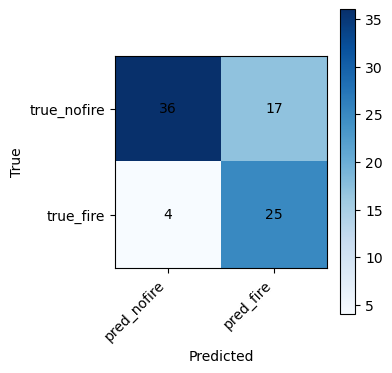

In [15]:
# Confusion matrix on validation set (heatmap)
import matplotlib.pyplot as plt

model.eval()
num_classes = len(dataset.classes)
conf_mat = torch.zeros(num_classes, num_classes, dtype=torch.int64)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
            conf_mat[t.long(), p.long()] += 1

row_labels = [f"true_{class_display.get(c, c)}" for c in dataset.classes]
col_labels = [f"pred_{class_display.get(c, c)}" for c in dataset.classes]
conf_df = pd.DataFrame(
    conf_mat.cpu().numpy(),
    index=row_labels,
    columns=col_labels
)

print(conf_df)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(conf_df.values, cmap="Blues")
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))
ax.set_xticklabels(col_labels, rotation=45, ha="right")
ax.set_yticklabels(row_labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, int(conf_df.values[i, j]), ha="center", va="center", color="black")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [16]:
from PIL import Image

# Batch prediction on one folder of images
test_path = "d:/new/Fire-Detection/0"  # change to your folder
model.eval()

results = []

for img_name in os.listdir(test_path):
    img_path = os.path.join(test_path, img_name)
    if not os.path.isfile(img_path):
        continue

    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    raw_label = dataset.classes[predicted.item()]
    label = class_display.get(raw_label, raw_label)
    results.append([img_name, label])

submission = pd.DataFrame(results, columns=["image", "prediction"])
submission.to_csv("./submission.csv", index=False)

print("Submission file saved!")


Submission file saved!


In [28]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import torch
from torchvision import transforms
import torch.nn.functional as F
import io

# Make sure model is in evaluation mode
model.eval()

# Same transforms used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Class names (adjust if needed)
classes = ['0', '1']

# Upload widget
uploader = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False
)

print("Upload an image:")
display(uploader)

def predict_image(change):
    for filename in uploader.value:
        # uploader.value[filename] is a Bunch object with attributes
        file_info = uploader.value[filename]
        content = file_info.content
        
        # Read image
        image = Image.open(io.BytesIO(content)).convert("RGB")
        display(image)
        
        # Preprocess
        img_tensor = transform(image).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs, 1)
        
        print(f"Prediction: {classes[predicted.item()]}")
        print(f"Confidence: {confidence.item()*100:.2f}%")

uploader.observe(predict_image, names='value')


Upload an image:


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

In [ ]:
import io
from PIL import Image as PILImage
from IPython.display import display
import torch
import torch.nn.functional as F
from torchvision import transforms

# Make sure device exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SAME transform used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

classes = ['0', '1']

if uploader.value:
    # uploader.value is a dict: {filename: Bunch object}
    filename = list(uploader.value.keys())[0]
    file_info = uploader.value[filename]
    content = file_info.content

    print(f"Uploaded image: {filename}")

    # Open image properly
    img = PILImage.open(io.BytesIO(content)).convert("RGB")
    display(img)

    # Preprocess
    input_image = transform(img).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        output = model(input_image)
        probs = F.softmax(output, dim=1)
        confidence, prediction = torch.max(probs, 1)

    print(f"Prediction: {classes[prediction.item()]}")
    print(f"Confidence: {confidence.item()*100:.2f}%")

else:
    print("No image uploaded yet. Please upload an image.")


No image uploaded yet. Please upload an image.


In [29]:
# Save trained model for Streamlit app
torch.save(model.state_dict(), 'fire_detection_model.pth')
print("✅ Model saved as 'fire_detection_model.pth' for Streamlit app!")


✅ Model saved as 'fire_detection_model.pth' for Streamlit app!
